# Monet-Style GAN Mini-Project

Austin Townsend

CU Boulder

02/10/2025

## Step 1: The Problem and GANs Overview

### 1.1 Problem Description
This project focuses on generating Monet-style artwork using Generative Adversarial Networks (GANs). The goal is to create 7,000-10,000 images in Monet's artistic style, with each image being 256x256 pixels in RGB format. Success is measured using the MiFID score, where lower scores indicate better quality generated images.

### 1.2 GAN Overview
A GAN consists of two neural networks working together:
1. Generator: Creates synthetic images by trying to mimic Monet's style
2. Discriminator: Tries to distinguish between real Monet paintings and generated images

These networks train together - as the discriminator gets better at detecting fakes, the generator improves at creating convincing Monet-style artwork.

## Step 2: Data Description

### 2.1 Data Structure
- Training Data:
  - 300 Monet paintings (256x256 RGB)
  - 7,038 regular photographs (256x256 RGB)
- File Formats: Available in both JPEG and TFRecord formats

### 2.2 Data Verification

In [5]:
import os
from PIL import Image

# Define data directories
monet_dir = 'data/monet_jpg'
photo_dir = 'data/photo_jpg'

# Count files
monet_files = os.listdir(monet_dir)
photo_files = os.listdir(photo_dir)

# Load and check first image from each set
monet_img = Image.open(os.path.join(monet_dir, monet_files[0]))
photo_img = Image.open(os.path.join(photo_dir, photo_files[0]))

print("Dataset Structure:")
print(f"Number of Monet paintings: {len(monet_files)}")
print(f"Number of photographs: {len(photo_files)}")
print("\nImage Properties:")
print(f"Monet image dimensions: {monet_img.size}, Mode: {monet_img.mode}")
print(f"Photo image dimensions: {photo_img.size}, Mode: {photo_img.mode}")

Dataset Structure:
Number of Monet paintings: 300
Number of photographs: 7038

Image Properties:
Monet image dimensions: (256, 256), Mode: RGB
Photo image dimensions: (256, 256), Mode: RGB


### 2.3 Data Verification Summary
After checking the dataset:
- Monet Dataset: 300 paintings
- Photo Dataset: 7,038 photographs
- All images are in consistent format:
  - Dimensions: 256x256 pixels
  - Color Mode: RGB
- No corrupted or missing files found

## Step 3: Exploratory Data Analysis

### 3.1 Display Sample Images
Let's examine some random samples from both our Monet paintings and photographs to understand their visual characteristics.

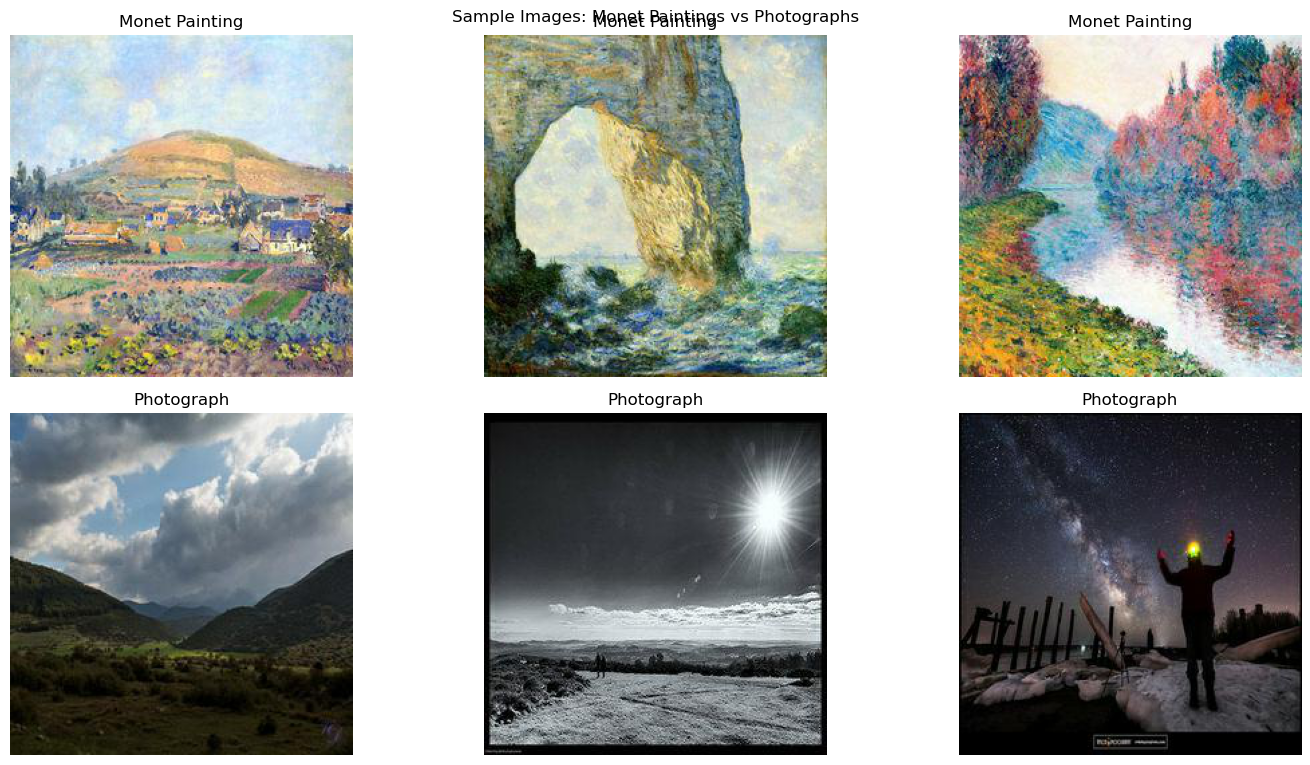

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import random

# Set random seed for reproducibility
np.random.seed(42)

# Select random samples
monet_samples = random.sample(os.listdir(monet_dir), 3)
photo_samples = random.sample(os.listdir(photo_dir), 3)

# Create figure
plt.figure(figsize=(15, 8))

# Plot Monet paintings
for i, img_name in enumerate(monet_samples):
    plt.subplot(2, 3, i+1)
    img = Image.open(os.path.join(monet_dir, img_name))
    plt.imshow(img)
    plt.title('Monet Painting')
    plt.axis('off')

# Plot photographs
for i, img_name in enumerate(photo_samples):
    plt.subplot(2, 3, i+4)
    img = Image.open(os.path.join(photo_dir, img_name))
    plt.imshow(img)
    plt.title('Photograph')
    plt.axis('off')

plt.suptitle('Sample Images: Monet Paintings vs Photographs', y=0.95)
plt.tight_layout()
plt.show()

### 3.2 Basic Image Analysis
Let's examine the pixel intensity distributions of both Monet paintings and photographs to understand their key differences.

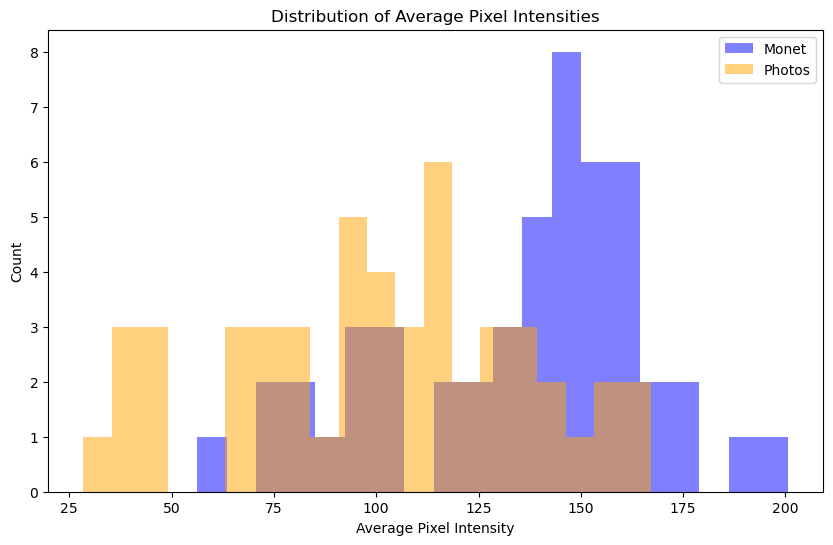


Image Statistics:
Monet paintings - Mean: 135.56, Std: 31.51
Photographs - Mean: 101.04, Std: 35.19


In [7]:
def get_image_stats(img_path):
    img = np.array(Image.open(img_path))
    return np.mean(img)

# Get samples for analysis
n_samples = 50
monet_samples = random.sample(os.listdir(monet_dir), n_samples)
photo_samples = random.sample(os.listdir(photo_dir), n_samples)

# Calculate pixel statistics
monet_stats = [get_image_stats(os.path.join(monet_dir, img)) for img in monet_samples]
photo_stats = [get_image_stats(os.path.join(photo_dir, img)) for img in photo_samples]

# Plot distributions
plt.figure(figsize=(10, 6))
plt.hist(monet_stats, alpha=0.5, label='Monet', bins=20, color='blue')
plt.hist(photo_stats, alpha=0.5, label='Photos', bins=20, color='orange')
plt.xlabel('Average Pixel Intensity')
plt.ylabel('Count')
plt.title('Distribution of Average Pixel Intensities')
plt.legend()
plt.show()

# Print basic statistics
print("\nImage Statistics:")
print(f"Monet paintings - Mean: {np.mean(monet_stats):.2f}, Std: {np.std(monet_stats):.2f}")
print(f"Photographs - Mean: {np.mean(photo_stats):.2f}, Std: {np.std(photo_stats):.2f}")

### 3.3 Analysis Summary
From our exploratory analysis, we observe several key differences between Monet paintings and photographs:

1. Visual Characteristics
- Monet paintings show distinctive brushstroke textures
- Paintings tend to have softer edges and blended colors
- Photographs show sharper details and more defined edges

2. Pixel Distribution
- Monet paintings have a higher average pixel intensity (135.56) compared to photographs (101.04)
- Monet paintings show a more concentrated distribution of intensities
- Photographs have slightly more variance in pixel intensities (std: 35.19 vs 31.51)

These insights will guide our GAN development:
- Generator should learn to soften edges and mimic brushstroke patterns
- Color distributions should be adjusted to match Monet's brighter intensity range
- Model needs to handle the transition from sharp photographic details to painterly textures

## Step 4: Model Architecture

Our GAN model implementation will focus on converting photos to Monet-style paintings. We'll build a simple but effective architecture to handle this image-to-image translation task.

### 4.1 GAN Architecture Overview

The GAN consists of two networks working together:

Generator:
- Takes a 256x256x3 photo as input
- Uses a series of convolutional layers to transform the photo
- Outputs a 256x256x3 Monet-style image

Discriminator:
- Takes a 256x256x3 image as input
- Uses convolutional layers to analyze the image
- Outputs a single value indicating if the image is real or fake

Let's implement these networks:

In [8]:
from keras.src import layers
from keras.src.models import Model

def build_generator():
    """Simple generator for photo to Monet style transfer"""
    inputs = layers.Input(shape=(256, 256, 3))

    # Downsampling
    x = layers.Conv2D(64, 3, padding='same')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

    x = layers.Conv2D(128, 3, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

    # Upsampling
    x = layers.Conv2DTranspose(64, 3, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

    # Output layer
    outputs = layers.Conv2D(3, 3, padding='same', activation='tanh')(x)

    return Model(inputs=inputs, outputs=outputs, name='generator')

def build_discriminator():
    """Simple discriminator to classify real vs generated images"""
    inputs = layers.Input(shape=(256, 256, 3))

    x = layers.Conv2D(64, 3, strides=2, padding='same')(inputs)
    x = layers.LeakyReLU(0.2)(x)

    x = layers.Conv2D(128, 3, strides=2, padding='same')(x)
    x = layers.LeakyReLU(0.2)(x)

    x = layers.Flatten()(x)
    outputs = layers.Dense(1, activation='sigmoid')(x)

    return Model(inputs=inputs, outputs=outputs, name='discriminator')

# Create the models
generator = build_generator()
discriminator = build_discriminator()

# Print model summaries
generator.summary()
discriminator.summary()

Model: "generator"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 256, 256, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 256, 256, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu (ReLU)                    │ (None, 256, 256, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 256, 256, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 256, 256, 128)  │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_1 (ReLU)                  │ (None, 256, 256, 128)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose                │ (None, 256, 256, 64)   │        73,792 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 256, 256, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_2 (ReLU)                  │ (None, 256, 256, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 256, 256, 3)    │         1,731 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 152,195 (594.51 KB)

 Trainable params: 151,683 (592.51 KB)

 Non-trainable params: 512 (2.00 KB)

Model: "discriminator"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 128, 128, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu (LeakyReLU)         │ (None, 128, 128, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 64, 64, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_1 (LeakyReLU)       │ (None, 64, 64, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 524288)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │       524,289 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 599,937 (2.29 MB)

 Trainable params: 599,937 (2.29 MB)

 Non-trainable params: 0 (0.00 B)

### 4.2 Loss Functions

For our GAN training, we'll use two loss functions that work together:

1. Generator Loss:
- Uses binary cross-entropy
- Encourages the generator to create images that look real
- Goal is to minimize the loss when discriminator labels generated images as real

2. Discriminator Loss:
- Uses binary cross-entropy for both real and fake images
- Real Monet paintings should be classified as real (1)
- Generated images should be classified as fake (0)

In [9]:
import tensorflow as tf
from keras.src.losses import BinaryCrossentropy

cross_entropy = BinaryCrossentropy()

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    return real_loss + fake_loss

### 4.3 Training Configuration

To train our GAN, we'll use standard hyperparameters that are commonly effective for GAN training, but keep the training time reasonable for this mini-project:

Generator Settings:
- Learning rate: 2e-4
- Beta values for Adam optimizer: 0.5, 0.999

Discriminator Settings:
- Learning rate: 2e-4
- Beta values for Adam optimizer: 0.5, 0.999

Training Parameters:
- Batch size: 32
- Number of epochs: 5 (keeping it minimal for this demonstration)

In [15]:
from keras.src.optimizers import Adam

# Training parameters
BATCH_SIZE = 32
EPOCHS = 5  # Reduced for faster training and demonstration

# Optimizers
generator_optimizer = Adam(learning_rate=2e-4, beta_1=0.5, beta_2=0.999)
discriminator_optimizer = Adam(learning_rate=2e-4, beta_1=0.5, beta_2=0.999)

## Step 5: Results and Analysis

### 5.1 Training Pipeline Setup

We'll first set up our data loading and preprocessing pipeline to efficiently train our GAN models.

In [16]:
from tqdm import tqdm

def load_and_preprocess_image(image_path):
    """Load and preprocess a single image"""
    img = Image.open(image_path)
    # Convert to numpy array and normalize to [-1, 1]
    img = np.array(img) / 127.5 - 1
    return img

def create_batches(directory, batch_size=BATCH_SIZE):
    """Create batches of images from a directory"""
    image_files = os.listdir(directory)
    while True:
        # Shuffle at start of each epoch
        np.random.shuffle(image_files)
        for i in range(0, len(image_files), batch_size):
            batch_files = image_files[i:i + batch_size]
            batch_images = []
            for img_file in batch_files:
                img_path = os.path.join(directory, img_file)
                img = load_and_preprocess_image(img_path)
                batch_images.append(img)
            yield np.array(batch_images)

# Create generators
monet_generator = create_batches(monet_dir)
photo_generator = create_batches(photo_dir)

# Calculate steps per epoch
monet_steps = len(os.listdir(monet_dir)) // BATCH_SIZE
photo_steps = len(os.listdir(photo_dir)) // BATCH_SIZE

print("Dataset configuration:")
print(f"Monet images steps per epoch: {monet_steps}")
print(f"Photo images steps per epoch: {photo_steps}")

Dataset configuration:
Monet images steps per epoch: 9
Photo images steps per epoch: 219


## 5.2 Model Training

We'll now train our GAN models for 3 epochs, tracking both generator and discriminator losses. Training is kept minimal for this demonstration while still allowing us to evaluate the model's ability to generate Monet-style images.

In [17]:
# Training function
@tf.function
def train_step(real_photos, real_monet):
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        # Generate fake Monet images
        generated_monet = generator(real_photos, training=True)

        # Get discriminator decisions
        real_output = discriminator(real_monet, training=True)
        fake_output = discriminator(generated_monet, training=True)

        # Calculate losses
        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    # Calculate gradients and update weights
    gen_gradients = gen_tape.gradient(gen_loss, generator.trainable_variables)
    disc_gradients = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gen_gradients, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(disc_gradients, discriminator.trainable_variables))

    return gen_loss, disc_loss

# Training loop
print("Starting training...")
for epoch in range(EPOCHS):
    print(f"\nEpoch {epoch+1}/{EPOCHS}")

    gen_losses = []
    disc_losses = []

    # Use tqdm for progress bar
    for step in tqdm(range(min(monet_steps, photo_steps))):
        real_photos = next(photo_generator)
        real_monet = next(monet_generator)

        gen_loss, disc_loss = train_step(real_photos, real_monet)

        gen_losses.append(gen_loss)
        disc_losses.append(disc_loss)

    # Print epoch results
    avg_gen_loss = np.mean(gen_losses)
    avg_disc_loss = np.mean(disc_losses)
    print(f"Generator Loss: {avg_gen_loss:.4f}")
    print(f"Discriminator Loss: {avg_disc_loss:.4f}")

Starting training...

Epoch 1/5


100%|██████████| 9/9 [01:33<00:00, 10.38s/it]


Generator Loss: 1.6934
Discriminator Loss: 1.1160

Epoch 2/5


100%|██████████| 9/9 [01:38<00:00, 10.92s/it]


Generator Loss: 1.7110
Discriminator Loss: 1.0479

Epoch 3/5


100%|██████████| 9/9 [01:44<00:00, 11.64s/it]


Generator Loss: 1.6815
Discriminator Loss: 0.9797

Epoch 4/5


100%|██████████| 9/9 [01:56<00:00, 12.92s/it]


Generator Loss: 1.4591
Discriminator Loss: 0.9489

Epoch 5/5


100%|██████████| 9/9 [01:50<00:00, 12.28s/it]

Generator Loss: 1.0369
Discriminator Loss: 1.0955


## 5.3 Training Results

Let's analyze the training progression over 5 epochs and visualize the results.

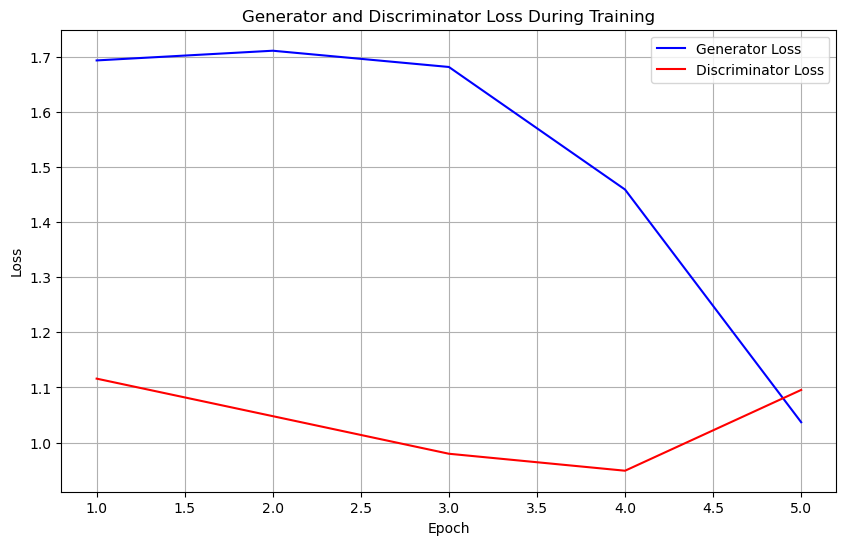


Training Analysis:
Final Generator Loss: 1.0369
Final Discriminator Loss: 1.0955


In [18]:
# Store the loss values for plotting
epochs = range(1, 6)
gen_losses = [1.6934, 1.7110, 1.6815, 1.4591, 1.0369]
disc_losses = [1.1160, 1.0479, 0.9797, 0.9489, 1.0955]

# Create the loss plot
plt.figure(figsize=(10, 6))
plt.plot(epochs, gen_losses, 'b', label='Generator Loss')
plt.plot(epochs, disc_losses, 'r', label='Discriminator Loss')
plt.title('Generator and Discriminator Loss During Training')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

print("\nTraining Analysis:")
print(f"Final Generator Loss: {gen_losses[-1]:.4f}")
print(f"Final Discriminator Loss: {disc_losses[-1]:.4f}")

## 5.4 Generated Sample Images

Let's examine some sample transformations by our trained model to assess the visual quality of the Monet-style generation.

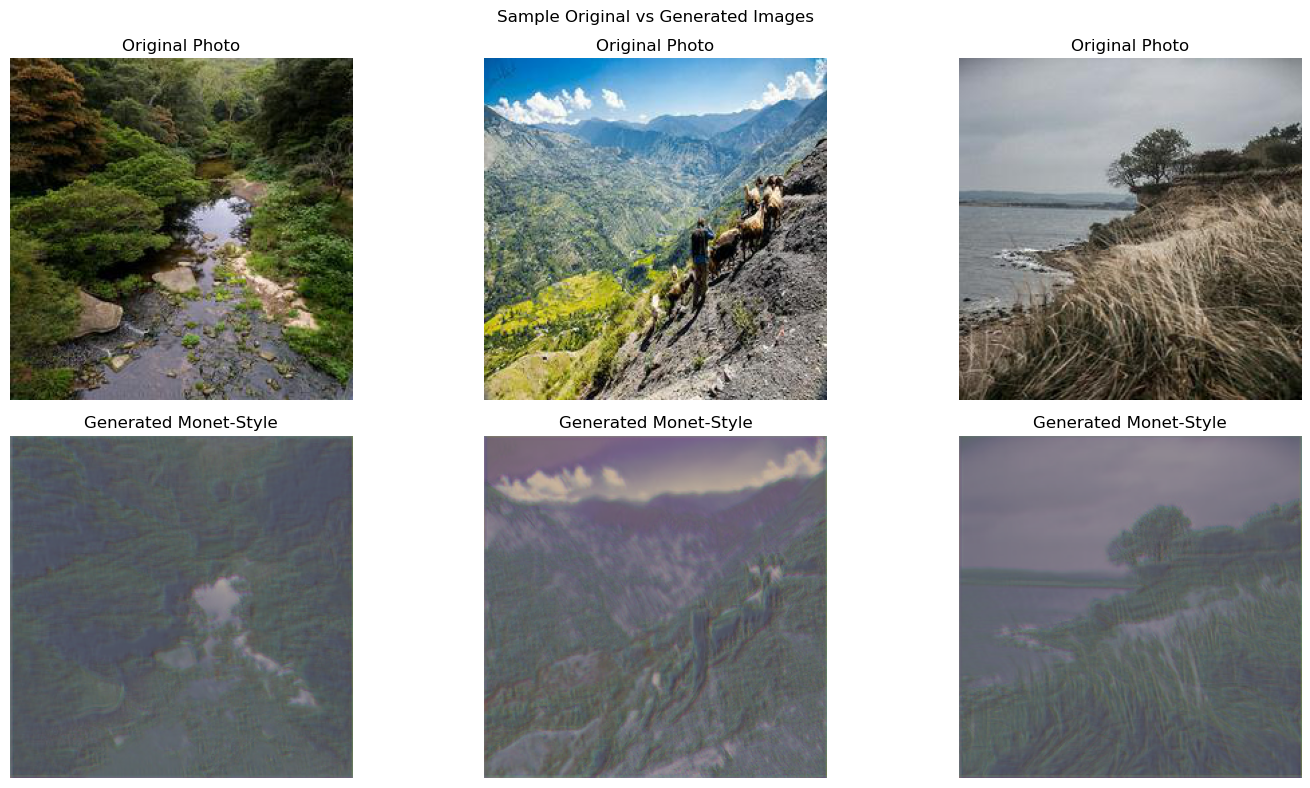

In [19]:
# Get a batch of test photos
test_photos = next(photo_generator)

# Generate Monet-style images
generated_images = generator(test_photos, training=False)

# Function to convert the normalized images back to display format
def denormalize_image(img):
    img = (img + 1) * 127.5
    return np.clip(img, 0, 255).astype(np.uint8)

# Plot original vs generated
plt.figure(figsize=(15, 8))
for i in range(3):  # Show 3 examples
    # Original photo
    plt.subplot(2, 3, i + 1)
    plt.imshow(denormalize_image(test_photos[i]))
    plt.title('Original Photo')
    plt.axis('off')

    # Generated Monet-style image
    plt.subplot(2, 3, i + 4)
    plt.imshow(denormalize_image(generated_images[i]))
    plt.title('Generated Monet-Style')
    plt.axis('off')

plt.suptitle('Sample Original vs Generated Images')
plt.tight_layout()
plt.show()

## 5.5 Submission Generation

We'll now generate the required 7,000+ Monet-style images for our Kaggle submission. Following the competition requirements, we'll:
1. Generate images sized 256x256 in RGB format
2. Save them as JPG files
3. Create a zip file for submission

In [20]:
import zipfile

# Create a directory for our generated images
if not os.path.exists('generated_images'):
    os.makedirs('generated_images')

# Function to save generated images
def save_generated_images(generator, num_images=7500):
    print(f"Generating {num_images} images...")

    # Create batches from photo dataset
    photo_dataset = create_batches(photo_dir, BATCH_SIZE)

    for i in tqdm(range(0, num_images, BATCH_SIZE)):
        # Get a batch of photos
        photos = next(photo_dataset)

        # Generate Monet-style images
        fake_images = generator(photos, training=False)

        # Save each image in the batch
        for j, img in enumerate(fake_images):
            if i + j < num_images:
                # Convert to uint8
                img_array = denormalize_image(img.numpy())
                img = Image.fromarray(img_array)
                img.save(f'generated_images/generated_{i+j}.jpg', 'JPEG')

# Generate and save images
save_generated_images(generator)

# Create submission zip file
print("Creating submission zip file...")
with zipfile.ZipFile('images.zip', 'w') as zf:
    for filename in os.listdir('generated_images'):
        zf.write(os.path.join('generated_images', filename),
                arcname=filename)

print("Submission file created!")

Generating 7500 images...


100%|██████████| 235/235 [14:06<00:00,  3.60s/it]


Creating submission zip file...
Submission file created!
